# **Deep Learning Homework 6: *Variational Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin & Dr. Luca Pasa
---

In this homework, we will explore how to develop a Variational Autoencoder (VAE). We will define a Variational Autoencoder starting from basic PyTorch components. Then, we will define a training loop which includes the two losses used to train VAEs, namely the reconstruction loss and the KL-divergence loss.
Using this training loop, we will fit the model on the MNIST dataset choosing  appropriate hyperparameters. Finally, we will and explore and analyze the latent encodings learned by the model thanks to some visualization techniques.

**Note**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime type* at the bottom of the page, and then select the GPU hardware accelerator.


#Requirements

In [ ]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 992.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━

#Imports

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Data Loading and Preprocessing

We load the MNIST dataset. The dataset contains 60,000 training grayscale images and 10,000 testing image of handwritten digits. We chose to use a 128-dimensional batch in order to make the training process reasonably fast -- you should thus leave this value unchanged.

In [ ]:
Trns = transforms.ToTensor()
def preprocess(img):
  img = Trns(img)
  H, W = img.shape[1:]
  img = img.reshape((H*W, ))
  return img

MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=preprocess)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
batch_size = 128
dataloader = DataLoader(MNIST, batch_size=batch_size, shuffle=True)

Let us see one of the digits.

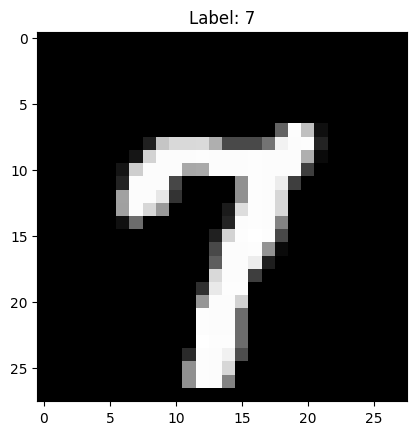

In [ ]:
data_iter = iter(dataloader)
images, labels = next(data_iter)

plt.imshow(images[0].reshape(28, 28), cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.show()

#[TO COMPLETE] VAE Architecture

###Exercise 6.1: Variational Autoencoder: reparameterization trick

To implement a VAE we have to define two main parts: the _Encoder_ and the _Decoder_.
Let's start by the Encoder, that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define a Sampling layer as a new layer.

In our case, the Sampling layer has in input the tuple made of the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:

$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$

The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon \sim \mathcal{N}(0,1)$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

As usual, we will provide the structure of the implementation of the VAE in PyTorch. The Encoder and Decoder are embodied by the `E_layers` and `D_layers` respectively.

**[TO COMPLETE]**: complete the code of the VAE model defining:

1. the dense layers that model `z_mean` and `z_var`;
2. the sampling function that implements the reparametrization trick;
3. the reparameterization trick in the forward function.

*Hint*: to generate random values from a normal distribution you can use the PyTorch [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html) function, and make sure the output shape is the proper one.


`%STARTCODE%`

In [ ]:
class VAE(nn.Module):
  def __init__(self, input_dim, ENC_LAYERS, latent_dim, DEC_LAYERS, act_fun, last_layer_act_fun):
    super().__init__()

    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.latent_dim = latent_dim

    activation_functions = {'linear': transforms.Lambda(lambda x: x),
                            'sigmoid': F.sigmoid,
                            'relu': F.relu,
                            'tanh': F.tanh,
                            'leaky_relu': F.leaky_relu}
    assert act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[act_fun]
    self.last_af = activation_functions[last_layer_act_fun]

    for layer_idx in range(len(ENC_LAYERS)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, ENC_LAYERS[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(ENC_LAYERS[layer_idx - 1], ENC_LAYERS[layer_idx]))

    ### TO COMPLETE [START] ####
    # 1. Define the dense layers that model z_mean and z_var
    self.linear_mean = nn.Linear(ENC_LAYERS[-1], latent_dim)
    self.linear_var = nn.Linear(ENC_LAYERS[-1], latent_dim)
     ### TO COMPLETE [END] ####

    if len(DEC_LAYERS) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(ENC_LAYERS[-1], input_dim))
    else:
      for layer_idx in range(len(DEC_LAYERS)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(latent_dim, DEC_LAYERS[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(DEC_LAYERS[layer_idx-1], DEC_LAYERS[layer_idx]))

    self.final_fc = nn.Linear(DEC_LAYERS[-1], input_dim)

  def sampling(self, z_mean, z_var):
    ### TO COMPLETE [START] ####
    # 2. Write the sampling function that implements the reparametrization trick
    z = z_mean + torch.exp(z_var/2) * torch.randn_like(z_var).to(device)
    return z
    ### TO COMPLETE [END] ####

  def encode(self, x):
    """This function implements the encoder part of our VAE.
    It will also be useful to explore the latent space learned after training!
    """
    for layer in self.E_layers:
      x = self.af(layer(x))
    return x

  def decode(self, z):
    """This function implements the decoder part of our VAE.
    It will also be useful to explore the latent space learned after training!
    """
    for layer in self.D_layers:
      z = self.af(layer(z))

    out = self.final_fc(z)

    return self.last_af(out)

  def forward(self, x):
    x = self.encode(x)

    ### TO COMPLETE [START] ###
    # 3. Use the linear layers and the sampling function you defined above to compute the sample z
    self.mean = self.linear_mean(x)
    self.log_var = self.linear_var(x)
    self.z = self.sampling(self.mean, self.log_var)
    ### TO COMPLETE [END] ###

    return self.decode(self.z)

`%ENDCODE%`



#[TO COMPLETE] Loss Functions

Now we have defined the VAE but, since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the _Kullback-Liebler Divergence_. On the other hand, for the reconstruction loss we will use the _binary cross-entropy_ to compare each feature of a data point to the value in the reconstructed output.

**[TO COMPLETE]**: implement the reconstruction loss and the KL-divergence.

*Disclaimer*: to implement the reconstruction loss you can use function or classes already available in PyTorch, while you must implement the KL-divergence from scratch, explointing the attributes in the `VAE` class.

`%STARTCODE%`

In [ ]:
### TO COMPLETE [START] ###
# Let's define the reconstruction loss
REC_LOSS = nn.BCELoss(reduction='mean')

# Kullback-Liebler divergence loss
def KL_LOSS(model):
  # Get the mean and log variance from the model's latent space
  mean = model.mean
  log_var = model.log_var
  # Compute the KL divergence loss using the mean and log variance
  kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)
  return torch.mean(kl_loss)
### TO COMPLETE [END] ###

`%ENDCODE%`

#[TO COMPLETE] Training

We define the training loop. Notice how we set a $\beta$ parameter to weight the combination of the two losses.

In [ ]:
def train(model, optimizer, dataloader, epochs, Beta=1e-3):
  loss_train_rec, loss_train_kl, loss_train = [], [], []

  for epoch in range(epochs):
    model.train()
    n_train_batches, rec_train, kl_train, total_loss_train = 0, 0, 0, 0

    for idx, (img, _) in enumerate(dataloader):
      # Reset the gradient for all parameters
      optimizer.zero_grad()

      # Move the input to currently used device
      img = img.to(device)

      # Run the model
      rec_img = model(img)

      # Compute the loss for this sample
      rec_loss = REC_LOSS(rec_img, img)
      kl_loss = KL_LOSS(model)
      total_loss = rec_loss + Beta * kl_loss

      # Accumulate the loss for this epoch
      total_loss_train += total_loss
      rec_train += rec_loss
      kl_train += kl_loss

      # Compute the gradients and update weights
      total_loss.backward()
      optimizer.step()

      n_train_batches += 1

    # Compute losses for this epoch
    avg_loss_train = total_loss_train / n_train_batches
    avg_rec_loss_train = rec_train / n_train_batches
    avg_kl_loss_train = kl_train / n_train_batches

    # Store losses
    loss_train.append(avg_loss_train.item())
    loss_train_rec.append(avg_rec_loss_train.item())
    loss_train_kl.append(avg_kl_loss_train.item())

    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}", end=' ----- ')
      print(f"Reconstruction Loss: {avg_rec_loss_train:.8f}", end=' ----- ')
      print(f"Effective KL Loss: {Beta * avg_kl_loss_train:.8f}")

  return loss_train, loss_train_rec, loss_train_kl

In [ ]:
def plot_losses(loss_train, loss_rec, loss_kl):
  plt.subplot(2, 1, 1)
  plt.grid(True)
  plt.title("Reconstruction Loss")
  plt.plot(loss_rec)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  print("\n")

  plt.subplot(2, 1, 2)
  plt.title("KL Loss")
  plt.grid(True)
  plt.plot(loss_kl)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

**[TO COMPLETE]:**
your task is to make the VAE working well and learn the digits' representstions. Define the hyperparameters for the encoder and decoder layers. Explain choice for what concerns the number of layers, the layers sizes, and the activation functions in the cells below.

_Hint_: note that we should define the `latent_dim` (that is the dimension of $z$) to $2$. This choice is made to make possible to represent the results graphically.
Pay attention to the relation between the decoding and encoding layers.

`%STARTCODE%`

In [ ]:
### TO COMPLETE [START] ###
# ENC_LAYERS and DEC_LAYERS should be lists describing the number and size of encoding/decoding layers
input_dim = 784 # [fixed] dimension of the input data (MNIST images are 28x28 = 784)
ENC_LAYERS = [392, 196, 98] # number and size of the encoding layers
latent_dim = 2 # [fixed] dimension of the latent space
DEC_LAYERS = [98, 196, 392] # number and size of the decoding layers
act_fun = 'relu' # activation function for hidden layers
last_layer_act_fun = 'sigmoid' # [fixed] activation function for the last layer
### TO COMPLETE [END] ###

vae = VAE(input_dim, ENC_LAYERS, latent_dim, DEC_LAYERS, act_fun, last_layer_act_fun).to(device)
summary(vae, input_size=(input_dim, ))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [784]                     --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [392]                     307,720
│    └─Linear: 2-2                       [196]                     77,028
│    └─Linear: 2-3                       [98]                      19,306
├─Linear: 1-2                            [2]                       198
├─Linear: 1-3                            [2]                       198
├─ModuleList: 1-4                        --                        --
│    └─Linear: 2-4                       [98]                      294
│    └─Linear: 2-5                       [196]                     19,404
│    └─Linear: 2-6                       [392]                     77,224
├─Linear: 1-5                            [784]                     308,112
Total params: 809,484
Trainable params: 809,484
Non-trai

Let's train out model.

In [ ]:
lr = 1e-3
epochs = 30
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_rec, loss_kl = train(vae, optimizer, dataloader, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.25016826 ----- Reconstruction Loss: 0.24760081 ----- Effective KL Loss: 0.00256741
epoch: 2 -> Loss: 0.21111907 ----- Reconstruction Loss: 0.20585816 ----- Effective KL Loss: 0.00526099
epoch: 3 -> Loss: 0.19736862 ----- Reconstruction Loss: 0.19152951 ----- Effective KL Loss: 0.00583903
epoch: 4 -> Loss: 0.19182207 ----- Reconstruction Loss: 0.18568276 ----- Effective KL Loss: 0.00613933
epoch: 5 -> Loss: 0.18797968 ----- Reconstruction Loss: 0.18162417 ----- Effective KL Loss: 0.00635555
epoch: 6 -> Loss: 0.18512300 ----- Reconstruction Loss: 0.17863157 ----- Effective KL Loss: 0.00649148
epoch: 7 -> Loss: 0.18276989 ----- Reconstruction Loss: 0.17615856 ----- Effective KL Loss: 0.00661126
epoch: 8 -> Loss: 0.18116796 ----- Reconstruction Loss: 0.17447363 ----- Effective KL Loss: 0.00669437
epoch: 9 -> Loss: 0.17998910 ----- Reconstruction Loss: 0.17323050 ----- Effective KL Loss: 0.00675865
epoch: 10 -> Loss: 0.17886235 ----- Reconstruction Loss: 0.17205380 -----

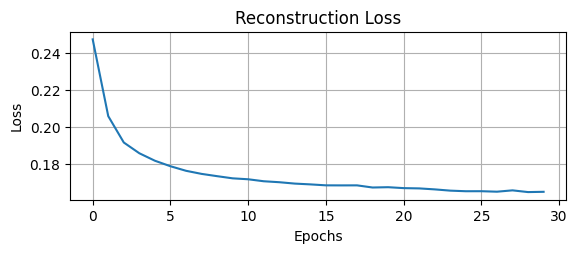

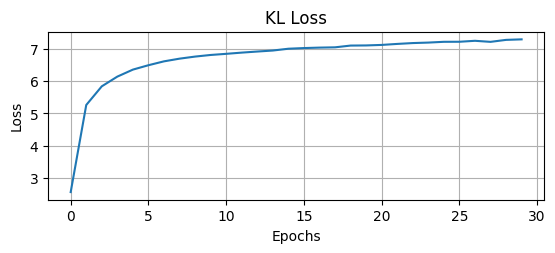

In [ ]:
plot_losses(loss_train, loss_rec, loss_kl)

`%ENDCODE%`

`%STARTEXT`

Comment on your choice of number of layers, the layers sizes, and the activation functions.

**Answer**:

In the following, we provide an explanation of the choices made for the hyperparameters in the VAE model.

* `input_dim`: it represents the dimension of the input data. For MNIST images, each image is a 28x28 grayscale image, resulting in 784 input dimensions when flattened. This choice is based on the specific structure of the input data;

* `ENC_LAYERS`: this parameter determines the number and size of the encoding layers in the VAE. These layers are responsible for extracting meaningful features from the input data. Here, we selected these particular sizes to gradually reduce the dimensionality and capture important features of the data;

* `latent_dim`: it represents the dimension of the latent space in the VAE. In this case, we set it to 2 for the purpose of visualization. A low-dimensional latent space allows us to plot and interpret the representations of the digits in a 2D space, facilitating analysis and understanding of the learned features;

* `DEC_LAYERS`: this parameter specifies the number and size of the decoding layers in the VAE. These layers mirror the encoding layers in reverse order and are responsible for reconstructing the input data from the latent space. By using the same layer sizes as the encoding layers, we create a symmetric structure that aids in the reconstruction process, enabling the decoder to generate output similar to the original input;

* `act_fun`: it determines the activation function used in the hidden layers of the VAE. We chose the ReLU (Rectified Linear Unit) activation function for its ability to capture non-linear relationships effectively;

* `last_layer_act_fun`: it specifies the activation function used in the last layer of the decoder. Since the input data consists of pixel intensities ranging from 0 to 1, we selected the sigmoid activation function. The sigmoid function scales the output to the range [0, 1], which aligns with the pixel intensity values of the image data.

By selecting these hyperparameters, we create a VAE model with an appropriate architecture for learning and representing the digits in the MNIST dataset. The chosen hyperparameters aim to capture the essential features of the data and facilitate the reconstruction and interpretation of the learned representations.

Additionally, it is evident that as the decrease in reconstruction loss occurs, there is a corresponding increase in KL loss. This phenomenon becomes apparent when examining the combined weight of the reconstruction loss and KL divergence. The primary aim is to strike a delicate equilibrium between achieving a reconstruction of superior quality for the images, akin to those obtained through a conventional autoencoder, and ensuring that the means of each cluster, which are formed through the addition of noise in the reparameterization trick, closely resemble a standard normal distribution with a mean of zero and an identity covariance matrix. This particular attribute facilitates the generation of samples by inputting a uniformly distributed grid in close proximity to zero into the decoder component of the variational autoencoder.

`%ENDTEXT`

#[TO COMPLETE] Generation

The best part about generative models is that they can generate new data (ChatGPT is pretty good at it 🙃). We can therefore plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.

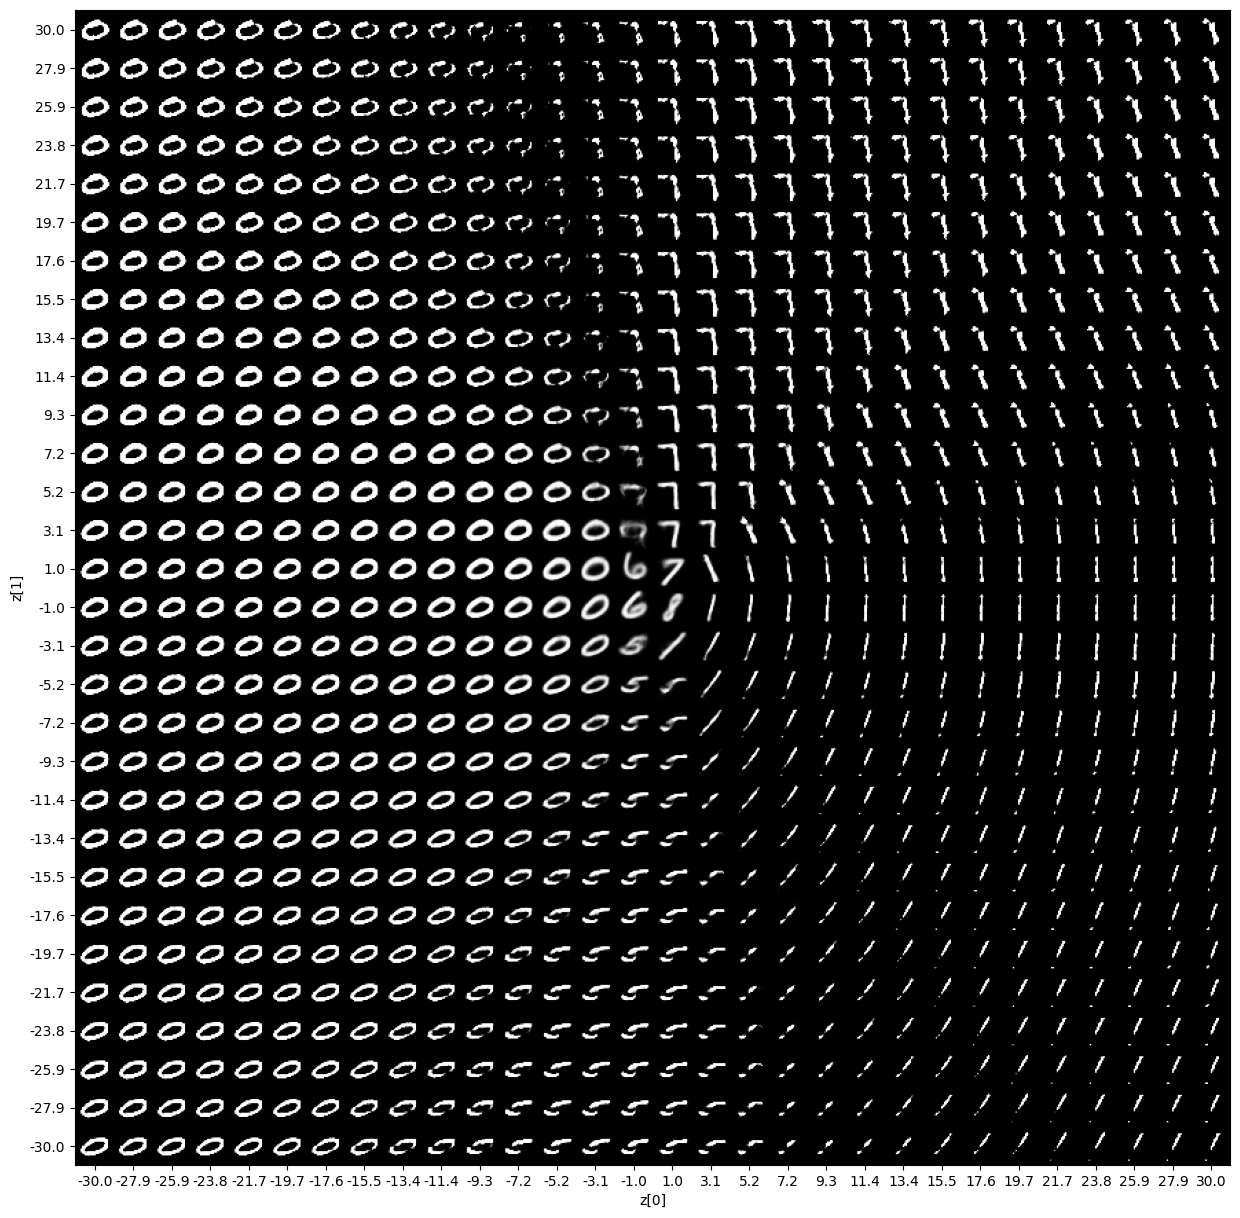

In [ ]:
def plot_latent(decoder, scale=2.0, n=30):
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    # Here we systematically generate 2D samples of z_hat
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # We cast and reshape the samples
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            # Then we pass them to the decoder, without keeping track of the gradient
            with torch.no_grad():
              x_decoded = vae.decode(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size).to('cpu')
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    # Finally we plot the generated data
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(2.0, 30)

The final result is quite impressive, considering that all these digits are artificial and they not belong to any dataset!
Let's finally check how the various digits have been represented in the latent space by the VAE.

In [ ]:
x_train, y_train = next(iter(DataLoader(MNIST, batch_size=len(MNIST))))

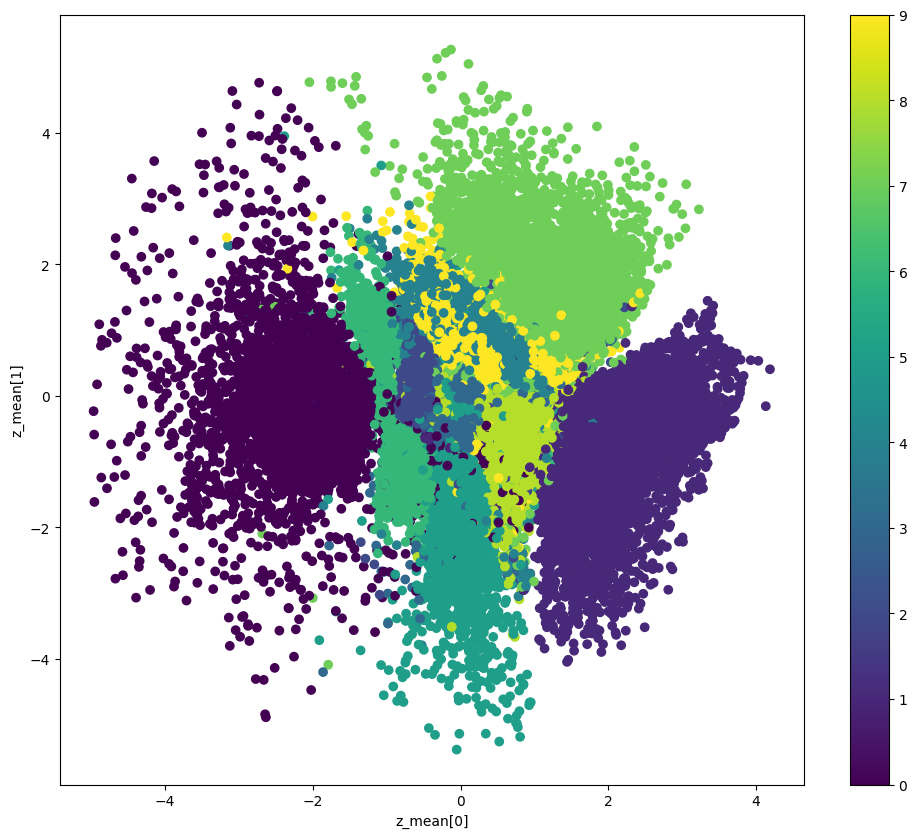

In [ ]:
def plot_label_clusters(data, labels):
    with torch.no_grad():
      # Let's compute the encodings
      encoding = vae.encode(data.to(device))
      # Then the mean used in the reparameterization trick
      z_mean = vae.linear_mean(encoding).to('cpu')

    # Let's plot the latent space
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z_mean[0]")
    plt.ylabel("z_mean[1]")
    plt.show()

plot_label_clusters(x_train, y_train)

**[TO COMPLETE]**: explore how the hyperparameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Discuss the obtained plots, and different hyperparameters you have tried. Insert your discussion below.

`%STARTEXT`

**Answer**:

The table below presents the results obtained from evaluating various VAE models. To ensure a fair comparison, certain parameters such as `epochs`, `l_r` (learning rate), Adam optimizer, `input_dim`, `latent_dim`, and `last_layer_act_fun` were kept constant across all models. By maintaining consistency in these parameters, we eliminate potential misleading factors and enable a meaningful evaluation of the different VAE architectures and hyperparameters. This approach ensures that any observed differences in performance can be attributed to the specific design choices and configurations of the models rather than variations in training settings.

|Model|ENC_LAYERS|DEC_LAYERS|act_fun|Loss|Reconstruction Loss|Effective KL Loss |
|---------|---------------|---------------|------------|-------------|---------------------|-------------------|
|VAE 1|[392, 196, 98]|[98, 196, 392]|relu|0.17202103|0.16472964|0.00729132|
|VAE 2|[392, 196, 98]|[98, 196, 392]|tanh|0.17377034|0.16658470|0.00718566|
|VAE 3|[392, 196, 98]|[98, 196, 392]|leaky_relu|0.17239599|0.16507366|0.00732233|
|VAE 4|[392, 196, 98]|[98, 196, 392]|linear|0.23055966|0.22682570|0.00373408|
|VAE 5|[392, 196]|[196, 392]|relu|0.17418474|0.16703679|0.00714807|
|VAE 6|[392, 196]|[196, 392]|tanh|0.17316075|0.16595280|0.00720799|
|VAE 7|[392, 196]|[196, 392]|leaky_relu|0.17335016|0.16614400|0.00720612|
|VAE 8|[196, 98]|[98, 196]|relu|0.17757000|0.17064984|0.00692004|
|VAE 9|[196, 98]|[98, 196]|tanh|0.17541565|0.16848193|0.00693370|
|VAE 10|[196, 98]|[98, 196]|leaky_relu|0.17739585|0.17044838|0.00694745|

Now, we will proceed with a brief analysis for the tested models on the obtained results, and consequently identify the best among them. In the end, we will draw some general considerations.

Among the models tested, **VAE 4** utilizing a linear activation function exhibited the highest overall loss of 0.23055966. This can be attributed to a relatively higher reconstruction loss and a comparatively lower effective KL loss. On the other hand, **VAE 2** and **VAE 6**, both employing the tanh activation function, demonstrated similar overall losses These models exhibited lower reconstruction losses and effective KL losses, suggesting a better balance between reconstruction quality and adherence to the latent space distribution.

Furthermore, it can be observed that models with different encoder and decoder layer configurations and the same activation function exhibited relatively consistent performance in terms of overall loss, reconstruction loss, and effective KL loss. For instance, **VAE 1**, **VAE 3**, and **VAE 7**, all utilizing the ReLU and leaky ReLU activation functions, displayed similar overall losses ranging from 0.17239599 to 0.17296326.

In the exploration of hyperparameters, it has been observed that the number of layers has a significant impact on the performance of the VAE. Increasing the number of layers generally improves the model's performance, as it allows for a more complex representation of the data. The additional layers enable the VAE to capture intricate patterns and nuances in the digits, resulting in improved distinguishability. Alternatively, reducing the number of layers leads to poorer results since the model lacks the capacity to store and learn the essential information required for accurate digit representation.

Also, the activation function plays an important role in shaping the VAE's learning capacity and performance. Activation functions like ReLU and leaky ReLU have shown to be beneficial, enabling the model to learn expressive representations and achieve better results in terms of reconstruction and KL loss. Conversely, activation functions like tanh and linear may lead to inferior performance, limiting the model's ability to capture intricate details and hinder convergence speed.

Regarding layer sizes, the number of units in the layers significantly influences the performance of the VAE. Increasing the layer sizes provides the model with a larger capacity to store and represent information. This increased capacity leads to improved performance, as the model can capture and learn more intricate details and features of the digits. On the other hand, decreasing the layer sizes restricts the model's capacity to store and represent information, resulting in a decline in performance. The model becomes limited in its ability to capture the complexity of the digits, leading to decreased accuracy and distinguishability.

Overall, **VAE 1** stands out as the top performer in terms of results. It demonstrates a better balance between reconstruction loss and effective KL loss, indicating a successful trade-off between accurately reconstructing the input data and effectively regularizing the latent space. The architecture, with its deeper encoding and decoding layers, allows for a more expressive representation of the data, resulting in improved performance in generating and distinguishing the different digits. The choice of the ReLU activation function in the hidden layers further enhances the model's capacity to capture intricate patterns and variations in the MNIST dataset.

`%ENDTEXT`